In [1]:
import os

os.environ["LL_DISABLE_TYPECHECKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


import ll
import rich
import torch

ll.pretty()

torch.no_grad().__enter__()
torch.inference_mode().__enter__()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [2]:
from jmppeft.tasks.finetune.base import FinetuneMatBenchDiscoveryIS2REDatasetConfig

dataset_config = FinetuneMatBenchDiscoveryIS2REDatasetConfig(
    # sample_n=DatasetSampleNConfig(sample_n=16, seed=42)
)
print(dataset_config)

dataset_og = dataset_config.create_dataset()
dataset_og, len(dataset_og)

[15:06:47] CRITICAL Type checking is disabled due to the environment variable                       ]8;id=277392;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py\typecheck.py]8;;\:]8;id=477105;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py#55\55]8;;\
                    LL_DISABLE_TYPECHECKING.                                                                       

           INFO     PyTorch version 2.2.2 available.                                                   ]8;id=299012;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py\config.py]8;;\:]8;id=416982;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py#58\58]8;;\


Loading 'wbm_summary' from cached file at '/nethome/nsg6/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


(<jmppeft.datasets.mpd_is2re.MatBenchDiscoveryIS2REDataset at 0x7f0786347690>,
 256963)

In [3]:
from pathlib import Path

run_id = "st1fu8ls"
ckpt_path = Path(
    f"/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/{run_id}/checkpoint/last.ckpt"
)
# If the file is a symlink, get the target
if ckpt_path.is_symlink():
    print(f"Symlink found {ckpt_path} => {ckpt_path.resolve()}")
    ckpt_path = ckpt_path.resolve()

ckpt_path

Symlink found /net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/last.ckpt => /net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/epoch=28-step=328251-val_matbench_discovery_force_mae=0.03183964639902115.ckpt


Path('/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/epoch=28-step=328251-val_matbench_discovery_force_mae=0.03183964639902115.ckpt')

In [4]:
from jmppeft.tasks.finetune import matbench_discovery as M

default_dtype = torch.float32
model = M.MatbenchDiscoveryModel.load_from_checkpoint(ckpt_path, map_location="cuda")
model = model.to(default_dtype)
model

[15:07:20] CRITICAL Using regular backbone                                                              ]8;id=648682;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=593597;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#605\605]8;;\

Unrecognized arguments:  dict_keys(['name', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'dropout', 'edge_dropout', 'ln_per_layer', 'scale_factor_to_ln'])


           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=265663;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=459659;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=360552;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=151844;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=920532;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=675330;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=340475;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=481368;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

[15:07:21] INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=562448;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=942389;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=215178;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=649974;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=253511;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=462603;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

[15:07:36] CRITICAL Constructed backbone with dlora=None                                                ]8;id=463015;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=471056;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#616\616]8;;\

           INFO     Registered 12 shared parameters                                         ]8;id=272767;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/model/modules/shared_parameters.py\shared_parameters.py]8;;\:]8;id=377127;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/model/modules/shared_parameters.py#72\72]8;;\

           INFO     List of ignored parameters: []                                                      ]8;id=939476;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=14688;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#694\694]8;;\

           CRITICAL Freezing 0 parameters (0.00%) out of 222,995,835 total parameters (222,995,835      ]8;id=792419;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=617089;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#923\923]8;;\
                    trainable)                                                                                     

MatbenchDiscoveryModel(config=MatbenchDiscoveryConfig(name=mptrj-jmp_l-direct-bsz32, project=jmp_mptrj), device=cuda:0)

In [5]:
from collections import Counter

import jmppeft.modules.dataset.dataset_transform as DT
import torch.utils._pytree as tree
from lightning.fabric.utilities.apply_func import move_data_to_device
from torch_geometric.data import Batch, Data


def data_transform(data: Data):
    data = model.data_transform(data)
    data = Data.from_dict(
        tree.tree_map(
            lambda x: x.type(default_dtype)
            if torch.is_tensor(x) and torch.is_floating_point(x)
            else x,
            data.to_dict(),
        )
    )
    return data


def composition(data: Batch):
    return dict(Counter(data.atomic_numbers.tolist()))


num_items = 1024

dataset = DT.transform(dataset_og, data_transform)
dataset = DT.sample_n_transform(dataset, n=num_items, seed=42)


idx = 32
data = Batch.from_data_list([dataset[idx]])
rich.print(
    data.to_dict(),
    composition(data),
)

{
    'pos': tensor[11, 3] n=33 x∈[-4.287, 6.937] μ=1.412 σ=2.423,
    'id': ['wbm-3-72883'],
    'atomic_numbers': tensor[11] i64 x∈[50, 79] μ=62.000 σ=14.269,
    'cell': tensor[1, 3, 3] n=9 x∈[-3.509, 6.938] μ=1.065 σ=4.112 [[[6.029, 0., -3.509], [-2.037, 5.674, -3.509], 
[0., 0., 6.938]]],
    'y_formation': tensor[1] [-0.236],
    'y_formation_correction': tensor[1] [0.],
    'y_above_hull': tensor[1] [0.093],
    'natoms': tensor[1] i64 [11],
    'tags': tensor[11] i64 x∈[2, 2] μ=2.000 σ=0.,
    'fixed': tensor[11] bool all_zeros,
    'batch': tensor[11] i64 all_zeros,
    'ptr': tensor[2] i64 μ=5.500 σ=7.778 [0, 11]
}
{66: 1, 50: 6, 79: 4}

In [6]:
from jmppeft.modules.relaxer import ModelOutput, Relaxer
from matbench_discovery.energy import get_e_form_per_atom


def model_fn(data, initial_data) -> ModelOutput:
    model_out = model.forward_denormalized(data)

    energy = model_out["y"]
    forces = model_out["force"]
    stress = model_out["stress"]

    # JMP-S v2 energy is corrected_energy, i.e., DFT total energy
    # This energy is now DFT total energy, we need to convert it to formation energy per atom
    energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": energy,
        }
    )
    assert isinstance(energy, torch.Tensor)

    # Add the correction factor
    if False:
        energy += initial_data.y_formation_correction.item()

    energy = energy.view(1)
    forces = forces.view(-1, 3)
    stress = stress.view(1, 3, 3) if stress.numel() == 9 else stress.view(1, 6)

    return {
        "energy": energy,
        "forces": forces,
        "stress": stress,
    }


data = move_data_to_device(data, model.device)
model_fn(data, data)

{'energy': tensor[1] cuda:0 [0.079],
 'forces': tensor[11, 3] n=33 x∈[-0.670, 0.714] μ=-0.001 σ=0.353 cuda:0,
 'stress': tensor[1, 3, 3] n=9 x∈[-0.128, -0.002] μ=-0.044 σ=0.061 cuda:0 [[[-0.125, -0.002, -0.003], [-0.002, -0.125, -0.004], [-0.003, -0.004, -0.128]]]}

In [7]:
from jmppeft.modules.relaxer import RelaxerConfig

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)
rich.print(data.y_formation)
relax_out = relaxer.relax(data)
# rich.print(relax_out)

energy = relax_out.atoms.get_total_energy()
rich.print(energy, data.y_formation)

tensor[1] cuda:0 [-0.236]

      Step     Time          Energy          fmax
FIRE:    0 15:07:37        0.078784        3.031601
FIRE:    1 15:07:37       -0.095927        1.384143
FIRE:    2 15:07:38       -0.144266        0.446446
FIRE:    3 15:07:38       -0.145645        0.446804
FIRE:    4 15:07:38       -0.147570        0.446575
FIRE:    5 15:07:38       -0.149968        0.449277
FIRE:    6 15:07:38       -0.152615        0.452442
FIRE:    7 15:07:38       -0.154820        0.448270
FIRE:    8 15:07:38       -0.156456        0.447664
FIRE:    9 15:07:38       -0.158140        0.446165
FIRE:   10 15:07:38       -0.160238        0.448047
FIRE:   11 15:07:38       -0.161869        0.445279
FIRE:   12 15:07:38       -0.165481        0.445151
FIRE:   13 15:07:38       -0.168856        0.441621
FIRE:   14 15:07:38       -0.172361        0.432870
FIRE:   15 15:07:39       -0.173740        0.424329
FIRE:   16 15:07:39       -0.178204        0.418815
FIRE:   17 15:07:39       -0.180696        0.396070
FIRE:   18 15:

-0.24463723599910736 tensor[1] cuda:0 [-0.236]

In [8]:
from collections import defaultdict

import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    # fmax=0.01,
    # ase_filter="frechet",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)

dl = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=model.collate_fn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

preds_targets = defaultdict[str, list[tuple[float, float]]](lambda: [])

for data in tqdm(dl, total=len(dl)):
    data = move_data_to_device(data, model.device)
    relax_out = relaxer.relax(data, verbose=False)

    e_form_true = data.y_formation.item()
    e_form_pred = relax_out.atoms.get_total_energy()
    preds_targets["e_form"].append((e_form_pred, e_form_true))

    e_above_hull_true = data.y_above_hull.item()
    e_above_hull_pred = e_above_hull_true + (e_form_pred - e_form_true)
    preds_targets["e_above_hull"].append((e_above_hull_pred, e_above_hull_true))

    nsteps = len(relax_out.trajectory.frames)

    print(
        f"# Steps: {nsteps}; e_form: P={e_form_pred:.4f}, GT={e_form_true:.4f}, Δ={abs(e_form_pred - e_form_true):.4f}"
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

# Steps: 21; e_form: P=-0.8636, GT=-0.8008, Δ=0.0628
# Steps: 32; e_form: P=-0.0340, GT=-0.0220, Δ=0.0120
# Steps: 9; e_form: P=-0.6890, GT=-0.6088, Δ=0.0803
# Steps: 32; e_form: P=-0.3421, GT=-0.1544, Δ=0.1877
# Steps: 45; e_form: P=-0.3295, GT=-0.1154, Δ=0.2141
# Steps: 19; e_form: P=-0.4030, GT=-0.3905, Δ=0.0126
# Steps: 17; e_form: P=-0.2836, GT=-0.2468, Δ=0.0368
# Steps: 10; e_form: P=-0.6248, GT=-0.4542, Δ=0.1706
# Steps: 16; e_form: P=-1.9867, GT=-1.9089, Δ=0.0777
# Steps: 6; e_form: P=-0.1435, GT=-0.1224, Δ=0.0212
# Steps: 5; e_form: P=-1.8799, GT=-1.8781, Δ=0.0017
# Steps: 11; e_form: P=-1.5739, GT=-1.6101, Δ=0.0362
# Steps: 22; e_form: P=-1.8545, GT=-1.8180, Δ=0.0365
# Steps: 2; e_form: P=-0.3268, GT=-0.3333, Δ=0.0065
# Steps: 13; e_form: P=-0.7460, GT=-0.7299, Δ=0.0161
# Steps: 4; e_form: P=-0.0590, GT=-0.0433, Δ=0.0157
# Steps: 31; e_form: P=-0.5650, GT=-0.5591, Δ=0.0059
# Steps: 16; e_form: P=-3.1459, GT=-3.0844, Δ=0.0615
# Steps: 10; e_form: P=-1.5672, GT=-1.7130, Δ=0.145

{'e_form': {'pred': (1024,), 'true': (1024,)}, 'e_above_hull': {'pred': (1024,), 'true': (1024,)}}

/tmp/ipykernel_3270302/3062433637.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


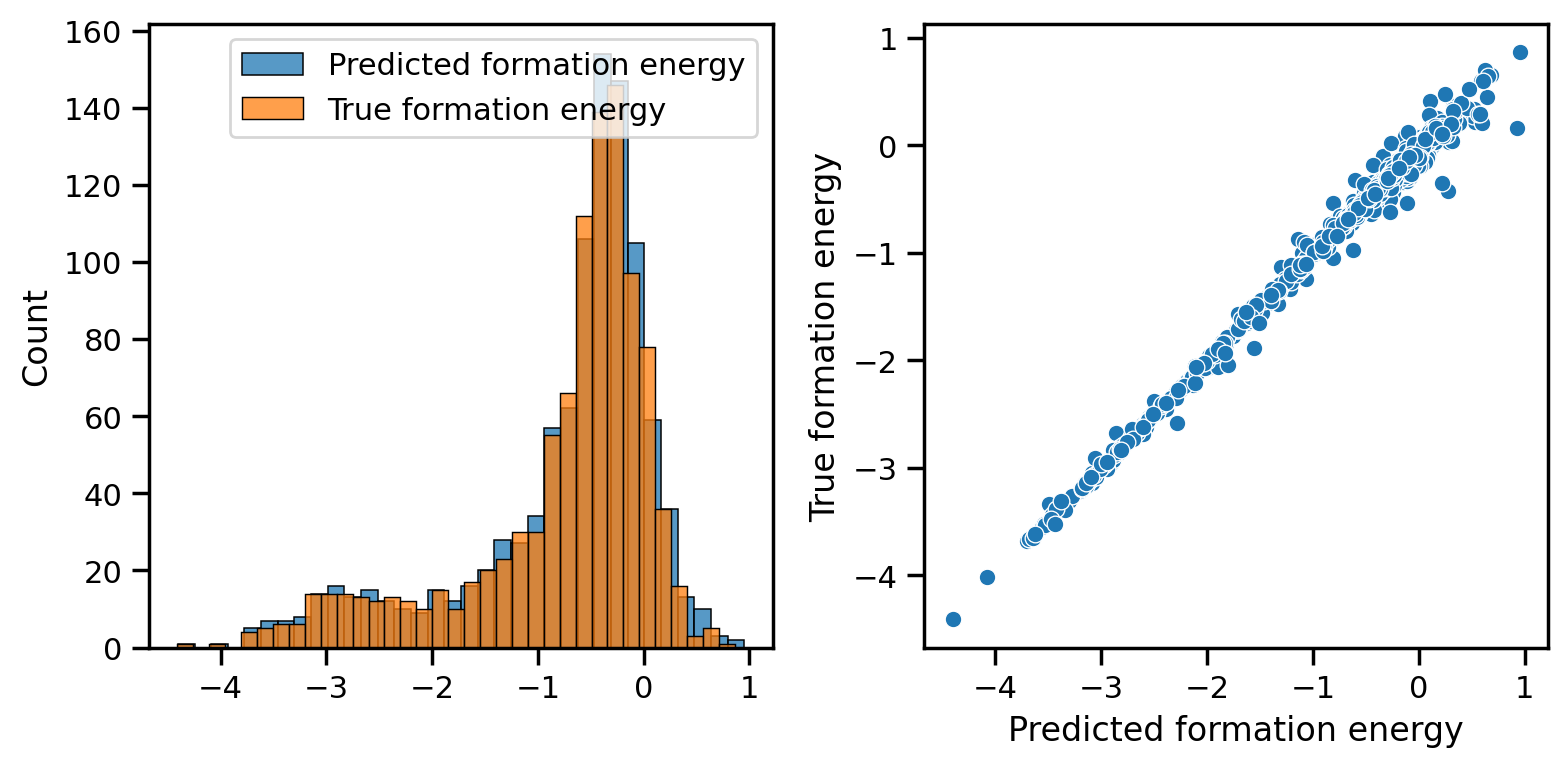

{
    'F1': 0.7193877551020408,
    'DAF': 3.825755166931638,
    'Precision': 0.8294117647058824,
    'Recall': 0.6351351351351351,
    'Accuracy': 0.892578125,
    'TPR': 0.6351351351351351,
    'FPR': 0.03615960099750624,
    'TNR': 0.9638403990024937,
    'FNR': 0.36486486486486486,
    'TP': 141,
    'FP': 29,
    'TN': 773,
    'FN': 81,
    'MAE': 0.04711788480369705,
    'RMSE': 0.08165495411606193,
    'R2': 0.9051014199191374
}

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matbench_discovery.metrics import stable_metrics

sns.set_context("notebook")

e_form_true, e_form_pred = zip(*preds_targets["e_form"])
e_form_true = np.array(e_form_true)
e_form_pred = np.array(e_form_pred)

e_above_hull_true, e_above_hull_pred = zip(*preds_targets["e_above_hull"])
e_above_hull_true = np.array(e_above_hull_true)
e_above_hull_pred = np.array(e_above_hull_pred)

rich.print(
    {
        "e_form": {"pred": e_form_pred.shape, "true": e_form_true.shape},
        "e_above_hull": {
            "pred": e_above_hull_pred.shape,
            "true": e_above_hull_true.shape,
        },
    }
)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

ax = axes[0]
sns.histplot(e_form_pred, label="Predicted formation energy", ax=ax)
sns.histplot(e_form_true, label="True formation energy", ax=ax)
ax.legend()

ax = axes[1]
sns.scatterplot(y=e_form_true, x=e_form_pred, ax=ax)
ax.set_xlabel("Predicted formation energy")
ax.set_ylabel("True formation energy")

fig.tight_layout()
plt.show()

metrics = stable_metrics(e_above_hull_true, e_above_hull_pred, fillna=False)
rich.print(metrics)